# Homework 1: Analyzing COVID-19 Data with Regression

In the coding part of this assignment we will conduct regression analysis on COVID-19 data to understand variables that affect COVID-19 growth rate. 

To complete this part of the assignment, follow along with the data loading and cleaning (running each cell as you go), looking up functions you are unfamiliar with and making sure you understand each step. While this part is not super fun, it is very important that you understand and are familiar with techniques for data manipulation so that you can use them later. When you arrive at the tasks, follow the instructions and then get started on your own research. 

Check out [this](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/) blog post for some Jupyter Notebook tips to get that work ~flowing~. Also, we use Pandas a lot in this assignment so if you are unfamiliar with this package and run into trouble, we recommend you check out a tutorial online. 


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.dates as mdates

## Loading Data

We got our data from Johns Hopkins Hopkins University. It gives us cumulative totals for confirmed cases, deaths, and recovered cases on the country level. The most up-to-date data can be found [here](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases) 

In [108]:
raw_confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
raw_deaths = pd.read_csv('time_series_covid19_deaths_global.csv')
raw_recovered = pd.read_csv('time_series_covid19_recovered_global.csv')

### Take a look at the structure of the data (the other data tables have the same structure)

In [109]:
raw_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


In [110]:
# Cleaning the data

confirmed = raw_confirmed.drop(['Lat','Long'], axis = 1)
deaths = raw_deaths.drop(['Lat','Long'], axis = 1)
recovered = raw_recovered.drop(['Lat','Long'], axis = 1)

# Removing province information so we have consistent country-level resolution

def set_country_res(df):

    df_sans_provinces = df.drop('Province/State', axis=1)
    df_sans_provinces = df_sans_provinces.groupby('Country/Region').sum()
    
    return df_sans_provinces

confirmed = set_country_res(confirmed)
deaths = set_country_res(deaths)
recovered = set_country_res(recovered)

confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
Albania,0,0,0,0,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
Algeria,0,0,0,0,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
Andorra,0,0,0,0,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
Angola,0,0,0,0,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


### Now let's visualize our data! We do this to make sure that our data is loaded in properly and matches our expectations -- if the data doesn't match you expectation you either made a mistake or a discovery (both are worth your time to find out early). As you work with data, remember to visualize early and often as a sanity check.

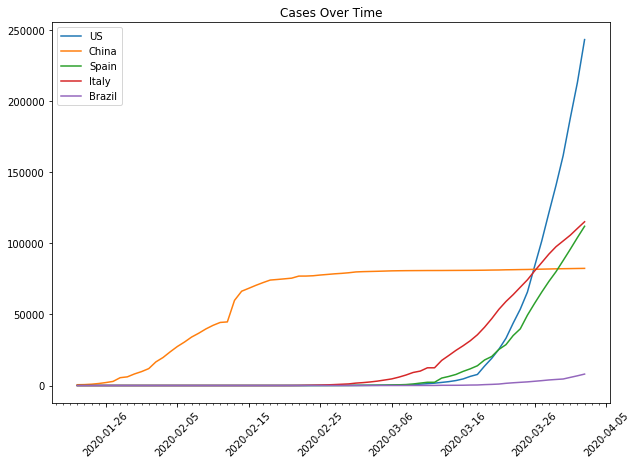

In [111]:
confirmed.columns = pd.to_datetime(confirmed.columns)

plt.figure(figsize = (10,7))
plt.xticks(rotation = 45)
plt.plot(confirmed.columns, confirmed.loc['US'], label = 'US')
plt.plot(confirmed.columns, confirmed.loc['China'], label = 'China')
plt.plot(confirmed.columns, confirmed.loc['Spain'], label = 'Spain')
plt.plot(confirmed.columns, confirmed.loc['Italy'], label = 'Italy')
plt.plot(confirmed.columns, confirmed.loc['Brazil'], label = 'Brazil')
plt.legend()

# Set xaxis tick marks to be regular
years_fmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))

plt.title('Cases Over Time')
plt.show()

### Gathering explanatory variables

In this assignment we are trying to investigate causal relationships and correlations between COVID-19 country data and possible population statistics that could affect infection and death rates. So now, we will show you how to load and join possible explanatory variables. 

It has been shown that older individuals are at [higher risk of death due to COVID-19](https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/older-adults.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fspecific-groups%2Fhigh-risk-complications%2Folder-adults.html) so we decided to investigate if the median age of a country is correlated with its death rate as an example.

In [112]:
# Load median age data
median_age = pd.read_csv('median_age.csv')
median_age.drop(['Median Male','Median Female'], axis=1, inplace=True)
median_age.rename(columns={'Median':'median_age', 'Place':'Country/Region'},inplace=True)
median_age.set_index('Country/Region', drop = True, inplace=True)
median_age.head()

,median_age
Country/Region,
Monaco,53.1
Japan,47.3
Germany,47.1
Saint Pierre and Miquelon,46.5
Italy,45.5


We can now calculate the death rate for each country. To do this we decided to use 

$death \; rate = \frac{deaths}{confirmed \; cases}$

because at the time of writing this assignment, the number of resolved cases was very low and likely underreported. If we had better data, a more accurate representation of the death rate would be to use resolved cases in the denominator (where $resolved \; cases = recovered + deaths$)



In [9]:
# Calculate death rate for each country

# Get most recent numbers for recovered and deaths (last column in the data table)
total_confirmed = confirmed[confirmed.columns[-1]]
total_deaths = deaths[deaths.columns[-1]]

death_rate = pd.Series(dtype = float)

# Calculating death rate
if (total_deaths.index == total_confirmed.index).all():
    death_rate = total_deaths/(total_confirmed + total_deaths)
else:
    print('Whoops, looks like your countries dont match')

# Drop countries that have a null death rate (don't have any cases)
death_rate.dropna(inplace=True)

death_rate = pd.DataFrame(death_rate)
death_rate.rename(columns={death_rate.columns[0]:'death_rate'},inplace=True)

A useful tool when working with multiple data tables is the merge function. This function merges two data tables (or columns from data tables) on a column or index of your choosing. One must be careful when merging because you can easily lose or multiply your data because of duplicate or mismatching keys. For this reason, it is important to always check the size of your new data table compared to the old ones. 

You can find more information about the pandas merge function [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) and a more in depth explanation of merges [here](https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/).

In [10]:
# Merging death rate and median age 
naive_merge = median_age.merge(death_rate,left_index=True, right_index=True)

We called our first merge a naive merge because we made the assumption that our two different data sources had all the same countries and named the countries the same. We will check that assumption in the next cell.

In [11]:
# Finding how many countries we lost in our naive merge
print(f'We lost {death_rate.shape[0] - naive_merge.shape[0]} countries in our naive merge')

# Finding the countries we lost
right_merge = median_age.merge(death_rate,left_index=True, right_index=True, how='right')
right_merge[right_merge.median_age.isnull()]

We lost 18 countries in our naive merge


,median_age,death_rate
Country/Region,,
Bahamas,NaN,0.040000
Burma,NaN,0.047619
Cabo Verde,NaN,0.142857
Congo (Brazzaville),NaN,0.083333
Congo (Kinshasa),NaN,0.088435
Cote d'Ivoire,NaN,0.005128
Czechia,NaN,0.011276
Diamond Princess,NaN,0.015214
Eswatini,NaN,0.000000


Of the countries that we lost, we are going to add back the US and South Korea (which is called 'Korea, South' in the data set for some reason). To do this, we simply need to make the names match. 

In [206]:
# To find the corresponding names in the median_age table, we guessed the obvious names 
# and they worked: 'United States' and 'South Korea'

# But if you can't find a name you can try this
# for country in median_age.index:
#     print(country)

# Now we will rename them in the median_age data (so it is consistent with the rest of our data)
median_age.rename(index={'United States':'US','South Korea':'Korea, South'}, inplace=True)

# Redoing our merge
deaths_and_age = median_age.merge(death_rate, left_index=True, right_index=True)

# Make sure it worked, we should have 2 fewer missing countries
print(f'We lost {death_rate.shape[0] - deaths_and_age.shape[0]} countries in our merge')

We lost 16 countries in our merge


### Now that we have workable data let's visualize it.

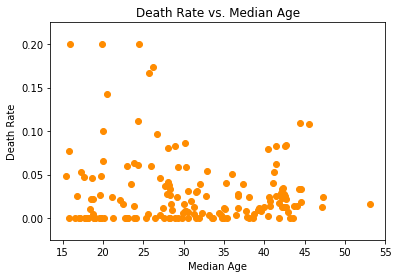

In [13]:
plt.scatter(deaths_and_age.median_age, deaths_and_age.death_rate, color='darkorange')
plt.ylabel('Death Rate')
plt.xlabel('Median Age')
plt.title('Death Rate vs. Median Age')
plt.show()

### Based on our initial scatter plot a linear relationship doesn't look super promising but let's try it anyway

You can find more information about the package we used for the linear regression [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).

p-values: 0.35339370626947875
R^2: 0.005285847299216592
Slope: -0.00032013215700298314


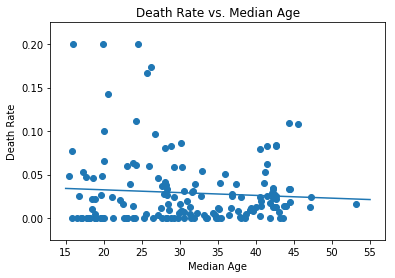

In [285]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(deaths_and_age.median_age, deaths_and_age.death_rate)
predictions = np.linspace(15,55,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.ylabel('Death Rate')
plt.xlabel('Median Age')
plt.title('Death Rate vs. Median Age')
plt.scatter(deaths_and_age.median_age, deaths_and_age.death_rate)
plt.plot(np.linspace(15,55,5), predictions)
plt.show()


As we predicted, our linear regression was not successful (as of the writing of this assignment). We encourage you to do your own research on methods of assessing regressions if you don't already have experience in this area and the grutors are happy to talk about it as well. Our regression above is likely an example of 'garbage in, garbage out'. This means that you can't get good information from bad data and coronavirus data is anything but consistent across countries, so you need to be careful about conclusions you draw from your analysis.

Now we have to ask ourselves if we truly believe that age is not a factor in death rate or if our data is misrepresenting reality. Now this is where you come in. You may have noticed that some countries have extremely high death rates that are inconsistent with what we know about the virus. This is likely because the sample size is far too small and furthermore is biased towards critical cases due to a lack of testing. While we can't fix the testing problem, we can try to make the data more reliable by filtering based on sample size. 

Your first task is to filter the data based on a minimum sample size that you deem appropriate (we chose 1000 on March 28th) then re-run the regression and interpret the results. Don't worry if you don't get statistically significant/logical results. 

__Don't forget to save important graphs and statistics for your deliverable.__


## Task 1: Filter on Sample Size and Re-Run Regression


In [15]:
# Get an idea of the numbers of resolved cases for most countries
total_confirmed.describe()

count       181.000000
mean       5597.552486
std       23883.385484
min           1.000000
25%          20.000000
50%         233.000000
75%        1317.000000
max      243453.000000
Name: 2020-04-02 00:00:00, dtype: float64

In [193]:
# Creating dataframes to edit

# the three dfs we want to use
confirmed_df = confirmed
deaths_df = deaths
median_age_df = median_age

# obtaining the relevant columns
confirmed_df = confirmed_df.filter([confirmed_df.columns[-1]])
deaths_df = deaths_df.filter([deaths_df.columns[-1]])

# combining the confirmed_df and median_age_df with the death_df
total_cases = confirmed_df
deaths_df.rename(columns = {'4/2/20' : "Total Deaths"}, inplace = True)
deaths_df['Total Cases'] = total_cases
deaths_df['Median Age'] = median_age_df

# our merged and editable df 
merge_df = deaths_df

In [222]:
# filtering our df for sample size and NaN

# removing NaN from our df
merge_df.dropna(inplace=True)
# missing US and south Korea
# merge_df.index

# adding sample size conidition
cases_cond = merge_df['Total Cases'] >= 1000
merge_df_samp = merge_df[cases_cond]

In [232]:
# finding death rate

# getting cases and death for each country
total_cases_filt = merge_df_samp['Total Cases']
total_deaths_filt = merge_df_samp['Total Deaths']

death_rate_filt = pd.Series(dtype = float)

# Calculating death rate
if (total_deaths_filt.index == total_cases_filt.index).all():
    death_rate_filt = total_deaths_filt/(total_cases_filt)
else:
    print('Whoops, looks like your countries dont match')

# creating death_rate_filt df
death_rate_filt = pd.DataFrame(death_rate_filt)
death_rate_filt.rename(columns={death_rate_filt.columns[0]:'death_rate'},inplace=True)

In [245]:
# creating death and age df and creating vars for graph

# combining the dfs and relabeling columns
death_rate_filt['Median Age'] = median_age_df
death_rate_filt.rename(columns = {'death_rate' : "Death Rate"}, inplace = True)
death_and_age_filt = death_rate_filt

# assiging vars for graph
death_rate_graph = death_and_age_filt["Death Rate"]
median_age_graph = death_and_age_filt["Median Age"]

p-values: 0.19129095079483016
R^2: 0.036054248451831604
Slope: 0.0008102589143363457


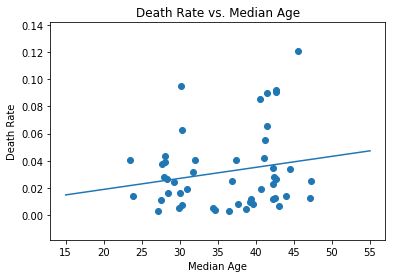

In [294]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(median_age_graph, death_rate_graph)
predictions = np.linspace(15,55,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')
plt.ylabel('Death Rate')
plt.xlabel('Median Age')
plt.title('Death Rate vs. Median Age')

# Plot Results
plt.scatter(median_age_graph, death_rate_graph)
plt.plot(np.linspace(15,55,5), predictions)
plt.show()

## Results, Interpretation, and Discussion 
We have a p-value of 0.1913, an R^2 value of 0.0361, and a slope of 0.0008. This shows that there is a more positive correlation between age and death rate because of the positive slope (albeit a very small correlation). However, we cannot reject the null hypothesis (our p-value is so high), so there is still the possibility of there being no statistically significance between the two variables. It should be noted that our R^2 value is very low, which suggests that this data is not fitted properly. Perhaps a sample size of larger than 1000 cases would improve the regression model, and provide a more conclusive result or interpretation. It does make sense to me that the data would be better (in terms of fit) with the additional constraint of a sample size. 

## Task 2: Find Your Own Data
Now, armed with the code above, you should pose a research question, find and download your own data from the internet, import it and run regressions (at least 2) to investigate your question. For each regression, write what you expect the relationship to be before you run the regression, graph the data, discuss how your results support/refute your initial hypothesis, and what you would need to be more sure of your results. 

You are welcome to continue working at a global scale, but there is also state by state data (and even county level data) in the United States which might yield more interesting results [here](https://covidtracking.com/?fbclid=IwAR3WwZ1nX8qhwJkAi1uYahgpyV94V3xPs0v_RzBBycMPB7p01DMKyDcc9Bk).

There is a wealth of demographic data on the internet that you can couple with the COVID-19 data. You don't need to limit yourself to looking at the death rate, but you can look at any trends with respect to COVID-19 you find interesting.

You can run linear regressions, transform your data (to fit an exponential or quadratic function, for example), run a Multiple Linear Regression, or anything else the questions you want to answer require. Feel free to use all internet resources (as long as you don't copy graphs and results), and the grutors are happy to answer any questions you have.

### Make sure to save graphs and statistics!

## Research Question
How does death toll correlate with total hospitalizations across the US? If states have a high number of hospitalizations, then their death toll will be higher. The null hypothesis would be: there is no correlation (or statistical significance) between death toll and total hospitalizations in the US.

## Data Source and Description
The data came from The COVID Tracking Project's gitHub repository. This data shows a variety of statistics across states in the US, notably positive cases and deaths resulting from COVID19. 

In [276]:
states_df = pd.read_csv('states_current.csv')
states_df.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,negative,pending,...,death,hospitalized,total,totalTestResults,posNeg,fips,dateModified,dateChecked,notes,hash
0,AK,226,1.0,1.0,1.0,1.0,A,4.0,6842,NaN,...,7,27.0,7068,7068,7068,2,2020-04-08T19:00:00Z,2020-04-08T19:13:00Z,"Please stop using the ""total"" field. Use ""tota...",c8335d4a25edf3ca27653180527f5c6429ec3835
1,AL,2369,1.0,1.0,0.0,1.0,B,3.0,16753,NaN,...,66,314.0,19122,19122,19122,1,2020-04-08T04:00:00Z,2020-04-08T19:15:00Z,"Please stop using the ""total"" field. Use ""tota...",fa2cee14c143c82cb6271b687a55dd5d9c9593d9
2,AR,1000,1.0,1.0,1.0,1.0,A,4.0,13530,NaN,...,18,130.0,14530,14530,14530,5,2020-04-08T18:35:00Z,2020-04-08T20:43:00Z,"Please stop using the ""total"" field. Use ""tota...",54ccf3c3afaaf7532078ff6e6525f441f0e28b07
3,AZ,2726,1.0,1.0,0.0,1.0,B,3.0,31838,NaN,...,80,NaN,34564,34564,34564,4,2020-04-08T04:00:00Z,2020-04-08T20:43:00Z,"Please stop using the ""total"" field. Use ""tota...",11c0f0559481c84f86c01b9361dabec2a2eceab3
4,CA,16957,1.0,1.0,0.0,1.0,B,3.0,127307,14600.0,...,442,NaN,158864,144264,144264,6,2020-04-07T22:00:00Z,2020-04-08T20:43:00Z,"Please stop using the ""total"" field. Use ""tota...",fc4bd42a5ad82a467e326ad3c277c9c9a4c741e0


In [314]:
# Filtering the data by sample size and removing NaN

# Sample size condition
states_filtered = states_df.filter(['state', 'positive', 'death', 'hospitalizedCumulative'])
size_cond = states_filtered['positive'] >= 2000
states_filtered = states_filtered[size_cond]

# NaN removal
states_filtered.dropna(inplace=True) 

# remove NY
# removeNY = states_filtered['positive'] < 149000
# states_filtered = states_filtered[removeNY]
states_filtered

,state,positive,death,hospitalizedCumulative
1,AL,2369,66,314.0
5,CO,5429,179,1079.0
9,FL,15455,309,2062.0
10,GA,9901,362,1993.0
19,MA,16790,433,1583.0
20,MD,5529,124,1210.0
25,MS,2003,67,410.0
34,NY,149316,6268,32669.0
35,OH,5148,193,1495.0
40,SC,2552,63,241.0


In [315]:
#vars for graph:
y_deaths = states_filtered["death"]
x_hosp = states_filtered["hospitalizedCumulative"]

p-values: 2.7223842959063155e-17
R^2: 0.9987340294380046
Slope: 0.19256218057629665


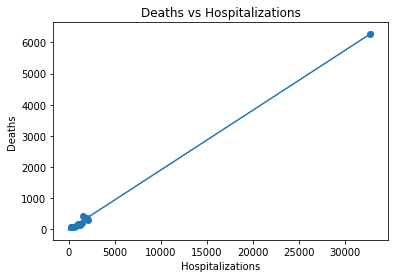

In [320]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(x_hosp, y_deaths)
predictions = np.linspace(0,33000,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.ylabel('Deaths')
plt.xlabel('Hospitalizations')
plt.title('Deaths vs Hospitalizations')
plt.scatter(x_hosp, y_deaths)
plt.plot(np.linspace(0,33000,5), predictions)
plt.show()

## Methods
I followed a similar process to the tutorial in terms of filtering out data. I decided to explore Deaths vs Hospitalizations for states within in the US. Similar to the previous graphs, I made to sure to add a minimum sample size. My choice to increase it to 2000 for this task was because of how increase sample sized improved the fit on the data in task 1. I also graphed deaths instead of death rate, as otherwise the graph would be even more scrunched into the bottom left corner. I comtemplated removing the point that is very far away from the graph, but since I did not do any calculations for outliers and the graph seems to have a good fit, I decided to leave it.

## Results
From this exploration we can see that there is a more positive trend for death toll and hospitalizations compared to the variables we observed in task 1 (the slope of the graph is more positive that in task 1, by about five times). Additionally, the regression fit is excellent as we have an R^2 value of almost one. However, we can not reject the null hypothesis due to the size of the p-value (approximately 2.72). Regardless, it seems that this is a topic that may deserve more exploration as more data arrises, because of the somewhat positive correlation between the two variables. It is not really conclusive, but, perhaps with more data and larger sample sizes that will change.

## Credibility
From the standpoint of where the data comes from, the source seems to be fairly credible (a lot of their data matches up with CDC numbers). However, I am not sure about the collection of the data. There may be a biases that deserve some contemplation in terms of how these statistics are recorded (i.e. are these deaths recorded from COVID19 being the main cause? Could there be other deaths not attributed to COVID19, but COVID19 was the cause for hospitalization? Could there be hospitalizations caused by something else, but death was resulted from COVID19?). However, for an exploratory search I believe this data should suffice to gain some insight into what kind of impact COVID19 is currently having.

## Task 3: 
I decided to take this course to learn more about big data, and how to use statistical tools to understand and use big data. Furthermore, it seems like this course could offer me a taste of machine learning before I take the class at Mudd, which I think would be quite beneficial. Additionally, I think the topic of the class is relevant and interests me, so I am quite curious and excited to be working with the data.

This assignment took me apporixmately 6 hours.